In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm
from copy import deepcopy
from IPython import display

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
work_dir = os.path.dirname(os.getcwd())

# 读取宋体训练图片和测试图片并存储为npy格式文件“train_images.npy”，“test_images.npy”并修改图片尺度为（224， 224， 3）方便下次使用

# 训练集6000张，测试集390张

In [18]:
"""
# 训练数据
train_path = './song/train/'
files = os.listdir(train_path)

# 每张图片的像素值并不都是 0 或者 255
train_images = []
for file in files:
    image = cv2.imread(train_path + file)
    # 修改为 (224, 224, 3) 尺度
    # interpolation=cv2.INTER_LINEAR
    image = cv2.resize(image, (224, 224))
    # cv2读取的图片是BGR格式，我们改成RGB格式
    B, G, R = cv2.split(image)
    image = cv2.merge([R, G, B])
    train_images.append(image)

train_images = np.array(train_images)

np.save("train_images.npy",train_images) 

# 测试数据
test_path = './song/test/'
files = os.listdir(test_path)

# 每张图片的像素值并不都是 0 或者 255
test_images = []
for file in files:
    image = cv2.imread(test_path + file)
    # 修改为 (224, 224, 3) 尺度
    # interpolation=cv2.INTER_LINEAR
    image = cv2.resize(image, (224, 224))
    # cv2读取的图片是BGR格式，我们改成RGB格式
    B, G, R = cv2.split(image)
    image = cv2.merge([R, G, B])
    test_images.append(image)

test_images = np.array(test_images)

np.save("test_images.npy",test_images) 
"""

# 读取宋体数据集并归一化

In [3]:
"""
train_images = np.load("train_images.npy")
test_images = np.load("test_images.npy")
# 将图片格式更改为np.float32并归一化至[-1, 1]
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5
# test_images = test_images.astype('float32')
# test_images = (test_images - 127.5) / 127.5
"""

# 读取行楷训练图片和测试图片并存储为npy格式文件“train_images.npy”，“test_images.npy”尺度为（256， 256， 3）方便下次使用

# 训练集3600张，测试集20张

In [17]:
"""
# 训练数据
train_path = './xingkai/train/'
files = os.listdir(train_path)

# 每张图片的像素值并不都是 0 或者 255
train_images = []
for file in files:
    image = cv2.imread(train_path + file)
    # cv2读取的图片是BGR格式，我们改成RGB格式
    B, G, R = cv2.split(image)
    image = cv2.merge([R, G, B])
    train_images.append(image)

train_images = np.array(train_images)

np.save("./xingkai/train_images.npy",train_images) 

# 测试数据
test_path = './xingkai/test/'
files = os.listdir(test_path)

# 每张图片的像素值并不都是 0 或者 255
test_images = []
for file in files:
    image = cv2.imread(test_path + file)
    # cv2读取的图片是BGR格式，我们改成RGB格式
    B, G, R = cv2.split(image)
    image = cv2.merge([R, G, B])
    test_images.append(image)

test_images = np.array(test_images)

np.save("./xingkai/test_images.npy",test_images) 
"""

In [6]:
# 读取已经储存好的行楷数据集
train_images = np.load(os.path.join(work_dir, "datasets\\xingkai\\train_images.npy"))
test_images = np.load(os.path.join(work_dir, "datasets\\xingkai\\test_images.npy"))

# 二值化

In [9]:
# 二值化
train_images[train_images >= 127.5] = 255
train_images[train_images < 127.5] = 0
test_images[test_images >= 127.5] = 255
test_images[test_images < 127.5] = 0

In [4]:
"""
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# 标准化图片到区间 [0., 1.] 内
train_images /= 255.
test_images /= 255.

# 二值化
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

# 我们写一个类似U-Net的编码器解码器来试试重构损失

In [10]:
BUFFER_SIZE = 3600
BATCH_SIZE = 8
STEPS_PER_EPOCH = 450
EPOCHS = 50
LAMBDA = 1000

In [11]:
# train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
# train_dataset

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

# 构造模型

二值化图片因为笔画分布差异较大，所以我们选用instance normalization

In [11]:
# 构造 Instance Normalization 层
# build: 创建图层的权重。使用add_weight方法添加权重
# call: 定义前向传播过程，即定义对输入张量的实际操作
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon # 用于variance的偏移
        
    # scale 和 offset 的 维度与 channels(kernels)的维度一致
    # 保证在非线性处理时保持x尺寸不变
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
        # 同 batchnorm一致，scale和offset是可训练更新的
    
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        # 这里注意一下， batchnorm 用的时候
        # mean, variance = tf.nn.moments(x, axes=[0], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

# 构造下采样block

In [12]:
def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
    """Downsamples an input.
      
    Conv2D => Batchnorm => LeakyRelu
      
    Args:
        filters: number of filters
        size: filter size
        norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
        apply_norm: If True, adds the batchnorm layer
    Returns:
        Downsample Sequential Model
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    
    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
    if apply_norm:
        if norm_type.lower() == 'batchnorm':
            block.add(tf.keras.layers.BatchNormalization())
        elif norm_type.lower() == 'instancenorm':
            block.add(InstanceNormalization())
    
    block.add(tf.keras.layers.LeakyReLU(0.2))
    
    return block

# 构造上采样block

In [13]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    """Upsamples an input.
    
    Conv2DTranspose => Batchnorm => Dropout => Relu
    
    Args:
        filters: number of filters
        size: filter size
        norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
        apply_dropout: If True, adds the dropout layer
    Returns:
        Upsample Sequential Model
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    
    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                             kernel_initializer=initializer,
                                             use_bias=False))
    if norm_type.lower() == 'batchnorm':
        block.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        block.add(InstanceNormalization())
    
    if apply_dropout:
        block.add(tf.keras.layers.Dropout(0.5))
        
    block.add(tf.keras.layers.ReLU())
    
    return block

# 构造Unet-Generator
构造 Generator
The architecture of generator is a modified U-Net.

Encoder
encoder: C64-C128-C256-C512-C512

All ReLUs in the encoder are leaky, with slope 0.2

So Each block in the encoder is (Conv -> instancenorm -> Leaky ReLU)

encoder第一个block C64 不用batchNorm

Decoder
decoder: -C512-C256-C128-C64

ReLUs in the decoder are not leaky

So Each block in the decoder is (Transposed Conv -> instancenorm -> Dropout(applied to the first 3 blocks) -> ReLU)

After the last layer in the decoder, a convolution is applied to map to the number of output channels (3 in general, except in colorization, where it is 2),

别忘了 skip-connection
The skip connections concatenate activations from layer i to layer n − i.

In [14]:
def Unet_Generator(norm_type='batchnorm'):
    """Modified u-net generator model.
    
    Args:
        output_channels: Output channels
        norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
    
    Returns:
        Generator model
    """
    inputs = tf.keras.layers.Input(shape=[224, 224, 3])
    
    down_stack = [
        downsample(64, 4, norm_type, apply_norm=False), # (112, 112, 64)
        downsample(128, 4, norm_type), # (56, 56, 128)
        downsample(256, 4, norm_type), # (28, 28, 256)
        downsample(512, 4, norm_type), # (14, 14, 512)
        downsample(512, 4, norm_type), # (7, 7, 512)
    ]
    
    up_stack = [
        upsample(512, 4, norm_type, apply_dropout=True), # (14, 14, 512)
        upsample(256, 4, norm_type, apply_dropout=True), # (28, 28, 256)
        upsample(128, 4, norm_type, apply_dropout=True), # (56, 56, 128)
        upsample(64, 4, norm_type), # (112, 112, 64)
    ]
    
    # 最后一层
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                          kernel_initializer=initializer,
                                          activation='sigmoid') # (224, 224, 3)
    
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
        
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

# 构造 Discriminator
The Discriminator is a PatchGAN.

C64-C128-C256-C512

After the last layer, a convolution is applied to map to a 1 dimensional output, followed by a Sigmoid function

Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU(slope=0.2))

BatchNorm is not applied to the first C64 layer.

# 注意感知域的计算
output_size = (input_size - kernel_size) / strides + 1

input_size = (output_size - 1) * strides + kernel_size

In [15]:
def Discriminator(norm_type='batchnorm'):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = tf.keras.layers.Input(shape=[224, 224, 3])
    x = inp
    
    down1 = downsample(64, 4, norm_type, False)(x) # (112, 112, 64)
    down2 = downsample(128, 4, norm_type)(down1) # (56, 56, 128)
    down3 = downsample(256, 4, norm_type)(down2) # (28, 28, 256)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (30, 30, 256)
    
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                 kernel_initializer=initializer,
                                 use_bias=False)(zero_pad1) # (27, 27, 256)
    if norm_type.lower() == 'batchnorm':
        norm1 = tf.keras.layers.BatchNormalization()(conv)
    elif norm_type.lower() == 'instancenorm':
        norm1 = InstanceNormalization()(conv)
    
    leaky_relu = tf.keras.layers.LeakyReLU(0.2)(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (29, 29, 256)
    
    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                 kernel_initializer=initializer)(zero_pad2) # (26, 26, 1)
    
    return tf.keras.Model(inputs=inp, outputs=last)

In [16]:
generator = Unet_Generator(norm_type='instancenorm')
discriminator = Discriminator(norm_type='instancenorm')

In [12]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 112, 112, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 56, 56, 128)  131328      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 28, 28, 256)  524800      sequential_1[0][0]               
______________________________________________________________________________________________

In [13]:
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_9 (Sequential)    (None, 112, 112, 64)      3072      
_________________________________________________________________
sequential_10 (Sequential)   (None, 56, 56, 128)       131328    
_________________________________________________________________
sequential_11 (Sequential)   (None, 28, 28, 256)       524800    
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 27, 27, 512)       2097152   
_________________________________________________________________
instance_normalization_10 (I (None, 27, 27, 512)       1024

# 损失函数

In [17]:
# Discriminator最后一层没有加sigmoid，所以注意from_logits参数
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

"""
the generator loss only need to fool discriminator
"""
def generator_loss(disc_gen):
    return loss_obj(tf.ones_like(disc_gen), disc_gen)

"""
discriminator的损失函数和DCGAN一致。
"""
def discriminator_loss(disc_real_output, disc_gen_output):
    real_loss = loss_obj(tf.ones_like(disc_real_output), disc_real_output)
    
    generated_loss = loss_obj(tf.zeros_like(disc_gen_output), disc_gen_output)
    
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss * 0.5

"""
加上 L1 reconstruction loss 
"""

def l1_loss(real_image, generated_image):
    loss = tf.reduce_mean(tf.abs(real_image - generated_image))
    return LAMBDA * loss

In [18]:
"""
定义Optimizer
We use minibatch SGD and apply the Adam solver, with learning rate 0.0002, 

and momentum parameters β1 = 0.5, β2 = 0.999.
"""

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# 构造 train_step()函数

In [19]:
@tf.function
def train_step(mask_image, real_image):
    # persistent 设置为 Ture，因为 GradientTape 被多次应用于计算梯度。
    with tf.GradientTape(persistent=True) as tape:
        fake_image = generator(mask_image)
        
        disc_real = discriminator(real_image)
        disc_fake = discriminator(fake_image)
        
        # 计算损失
        gen_ad_loss = generator_loss(disc_fake)
        gen_l1_loss = l1_loss(real_image, fake_image)
        # 总生成器损失
        gen_loss = gen_ad_loss + gen_l1_loss
        # 总判别器损失
        disc_loss = discriminator_loss(disc_real, disc_fake)
        
    # calculating gradients
    generator_grad = tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_grad = tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_grad, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_grad, discriminator.trainable_variables))

In [ ]:
"""
On each epoch it clears the display, and runs generate_images to show it's progress.

On each epoch it iterates over the training dataset.

"""

In [20]:
# 传进来的test_images是已经mask处理过并且normalize
def show_image(mask_images, real_images, model, epoch):
    predictions = model(mask_images, training=False).numpy()
    
    plt.figure(figsize=(24, 24))
    
    for i in range(16):
        plt.subplot(8, 6, 3*i+1)
        plt.title("Real Image")
        plt.imshow((real_images[i] * 255).astype(np.uint8))
        plt.axis('off')
        plt.subplot(8, 6, 3*i+2)
        plt.title("Mask Image")
        plt.imshow((mask_images[i] * 255).astype(np.uint8))
        plt.axis('off')
        plt.subplot(8, 6, 3*i+3)
        plt.title("Predicted Image")
        plt.imshow((predictions[i] * 255).astype(np.uint8))
        plt.axis('off')
    
    plt.savefig("./pics/image_at_epoch_{:02d}.png".format(epoch+1))
    plt.show()

# 定义preprocess函数，包括随机crop成224，224，随机生成mask，normalize到0~1

In [24]:
def preprocess(images, batch_size):
    real_images = []
    mask_images = []
    for idx in range(batch_size):
        image = images[idx] # 256 原图
        x = np.random.randint(33)
        y = np.random.randint(33)
        real_image = deepcopy(image[x: x+224, y: y+224, :])# 裁成 224×224
        mask_image = deepcopy(image[x: x+224, y: y+224, :])
        
        # 先处理mask_on_black
        mask_path = os.path.join(work_dir, "datasets\\mask_on_black\\block_")
        select = np.random.randint(148, size=(4, 4))
        # 把select的16张block整合为完整mask(横纵各4块,单块尺度为56×56)
        mask = np.zeros((224, 224, 3))
        for i in range(4):
            for j in range(4):
                block = cv2.imread(mask_path + str(select[i][j]) + '.png')
                mask[i*56:(i+1)*56, j*56:(j+1)*56, :] = block[:, :, :]
        # 如果mask的像素位置是白色，则书法字对应位置改为白色
        mask_image[mask == 255] = 255
        
        # 处理mask_on_white
        mask_path = os.path.join(work_dir, "datasets\\mask_on_white\\block_")
        select = np.random.randint(12, size=3)
        for i in select:
            block = cv2.imread(mask_path + str(i) + ".png")
            x = np.random.randint(50, 156)
            y = np.random.randint(50, 156)
            mask_image[x:x+28, y:y+28, :] = block[:, :, :]
        
        real_images.append(real_image)
        mask_images.append(mask_image)
        
    real_images = np.array(real_images)
    mask_images = np.array(mask_images)
    
    real_images = real_images.astype(np.float32)
    mask_images = mask_images.astype(np.float32)
    real_images /= 255.
    mask_images /= 255.
    return mask_images, real_images

In [25]:
examples = test_images[:16]
examples_mask, examples_real = preprocess(examples, 16)

In [26]:
# 每个epoch的操作
def train(train_images, epoch):
    np.random.shuffle(train_images)
    
    for i in tqdm(range(STEPS_PER_EPOCH)):
        images = train_images[i * BATCH_SIZE: (i + 1) * BATCH_SIZE, :, :, :]
        mask_images, real_images = preprocess(images, BATCH_SIZE)
        train_step(mask_images, real_images)
            
    display.clear_output(wait=True)
    # 使用一致的图像（example_test），以便模型的进度清晰可见。
    show_image(examples_mask, examples_real, generator, epoch)

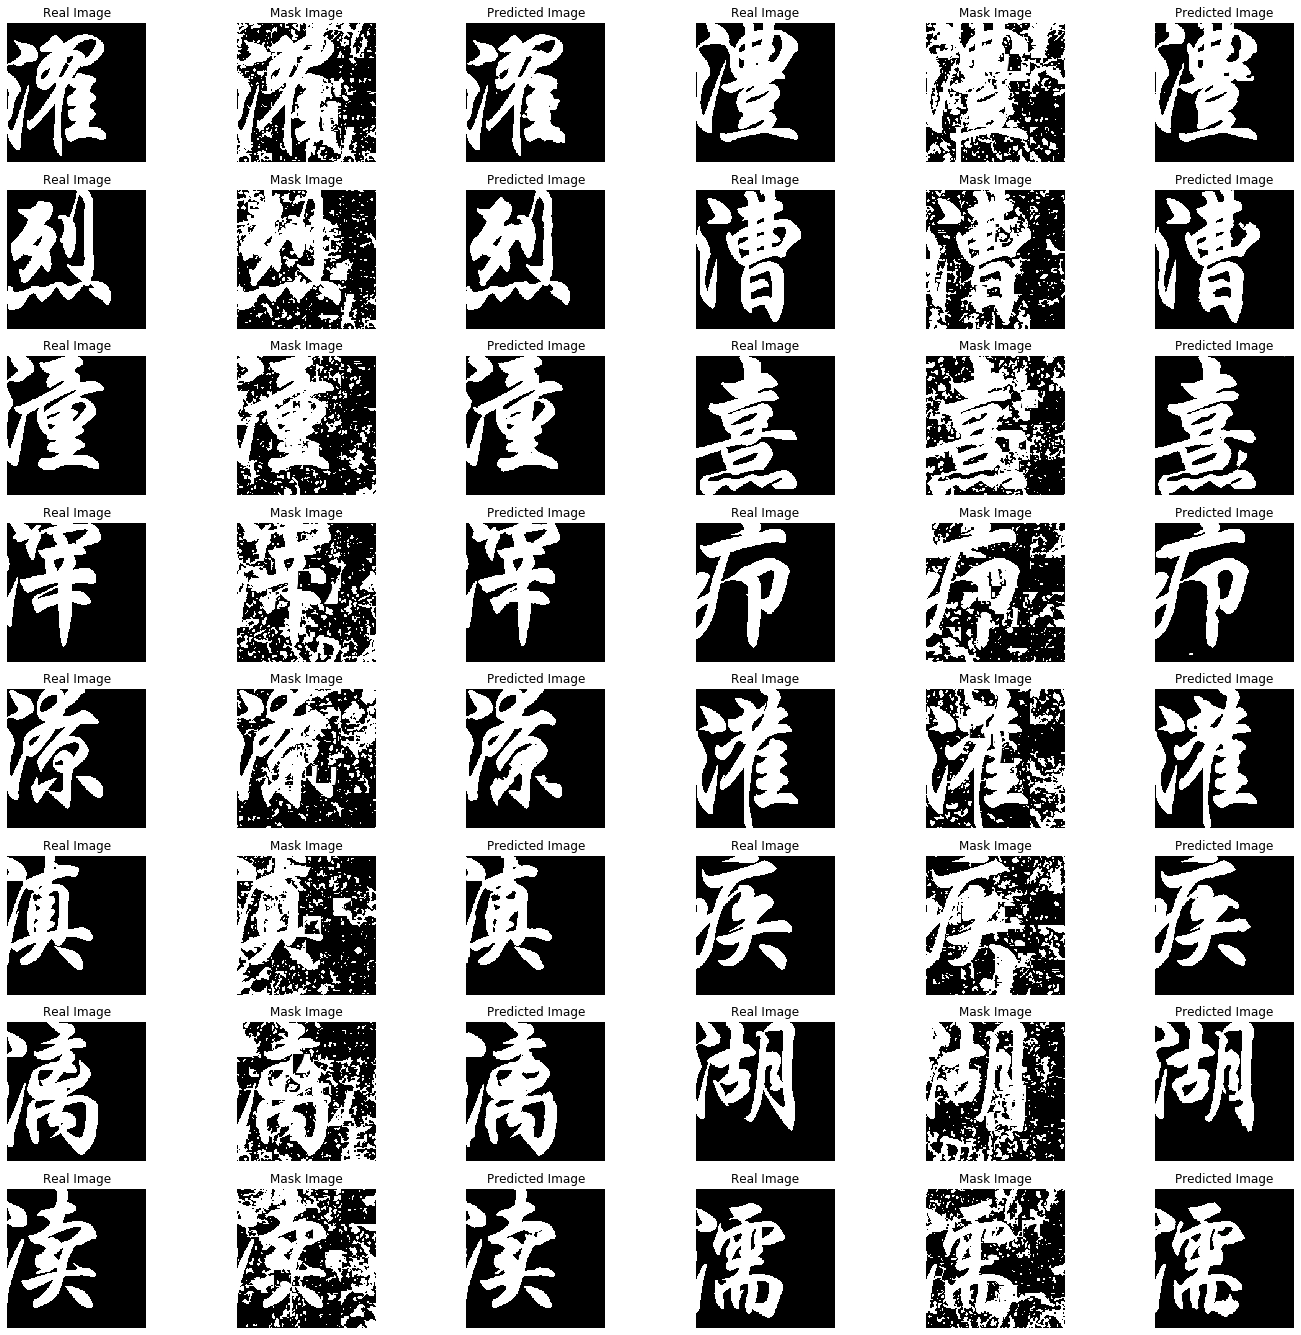

In [27]:
for epoch in range(EPOCHS):
    print('epoch %d', epoch)
    train(train_images, epoch)  